In [ ]:
#!/usr/bin/env python
# coding: utf-8

# Breast Cancer Wisconsin Dataset: Advanced ML Classification<br>
<br>
This notebook uses advanced machine learning techniques to predict whether a breast cancer tumor is malignant or benign using the Breast Cancer Wisconsin dataset.

## 1. Setup and Data Loading

Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
import xgboost as XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
import shap

Set plotting style

In [4]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

Set random seed for reproducibility

In [5]:
np.random.seed(42)

Load the Breast Cancer Wisconsin dataset

In [6]:
cancer = load_breast_cancer()

Create a DataFrame for easier handling

In [7]:
data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data['target'] = cancer.target

Display basic information about the dataset

In [8]:
print(f"Dataset shape: {data.shape}")
print(f"\nTarget names: {cancer.target_names}")
print(f"\nTarget distribution:\n{data['target'].value_counts()}")
print(f"\nFeatures:\n{cancer.feature_names}")

Dataset shape: (569, 31)

Target names: ['malignant' 'benign']

Target distribution:
target
1    357
0    212
Name: count, dtype: int64

Features:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


Display the first few rows of the dataset

In [9]:
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 2. Data Preprocessing

Check for missing values

In [10]:
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64


Separate features and target

In [11]:
X = data.drop('target', axis=1)
y = data['target']

Split the data into training and testing sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Normalize the features using StandardScaler

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Convert back to DataFrame for better readability

In [14]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [15]:
print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Training set shape: (455, 30)
Testing set shape: (114, 30)


In [16]:
X_train_scaled_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-1.072001,-0.658425,-1.088080,-0.939274,-0.135940,-1.008718,-0.968359,-1.102032,0.281062,-0.113231,...,-1.034094,-0.623497,-1.070773,-0.876534,-0.169982,-1.038836,-1.078995,-1.350527,-0.352658,-0.541380
1,1.748743,0.066502,1.751157,1.745559,1.274468,0.842288,1.519852,1.994664,-0.293045,-0.320180,...,1.228342,-0.092833,1.187467,1.104386,1.517001,0.249655,1.178594,1.549916,0.191078,-0.173739
2,-0.974734,-0.931124,-0.997709,-0.867589,-0.613515,-1.138154,-1.092292,-1.243358,0.434395,-0.429247,...,-0.973231,-1.036772,-1.008044,-0.834168,-1.097823,-1.167260,-1.282241,-1.707442,-0.307734,-1.213033
3,-0.145103,-1.215186,-0.123013,-0.253192,0.664482,0.286762,-0.129729,-0.098605,0.555635,0.029395,...,-0.251266,-1.369643,-0.166633,-0.330292,0.234006,0.096874,-0.087521,-0.344838,0.242198,-0.118266
4,-0.771617,-0.081211,-0.803700,-0.732927,-0.672282,-1.006099,-0.798502,-0.684484,0.737495,-0.457213,...,-0.801135,0.079230,-0.824381,-0.741830,-0.911367,-0.984612,-0.933190,-0.777604,0.555118,-0.761639


## 3. Exploratory Data Analysis (EDA)

Basic statistics of the dataset

In [17]:
data.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


Distribution of target variable

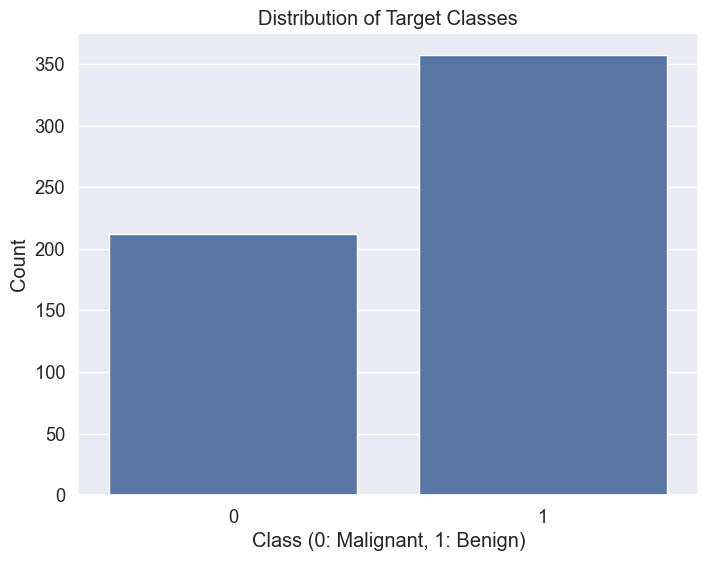

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=data)
plt.title('Distribution of Target Classes')
plt.xlabel('Class (0: Malignant, 1: Benign)')
plt.ylabel('Count')
plt.show()

Calculate class distribution percentage

In [19]:
class_counts = data['target'].value_counts(normalize=True) * 100
print(f"Malignant: {class_counts[0]:.2f}%")
print(f"Benign: {class_counts[1]:.2f}%")

Malignant: 37.26%
Benign: 62.74%


Correlation heatmap

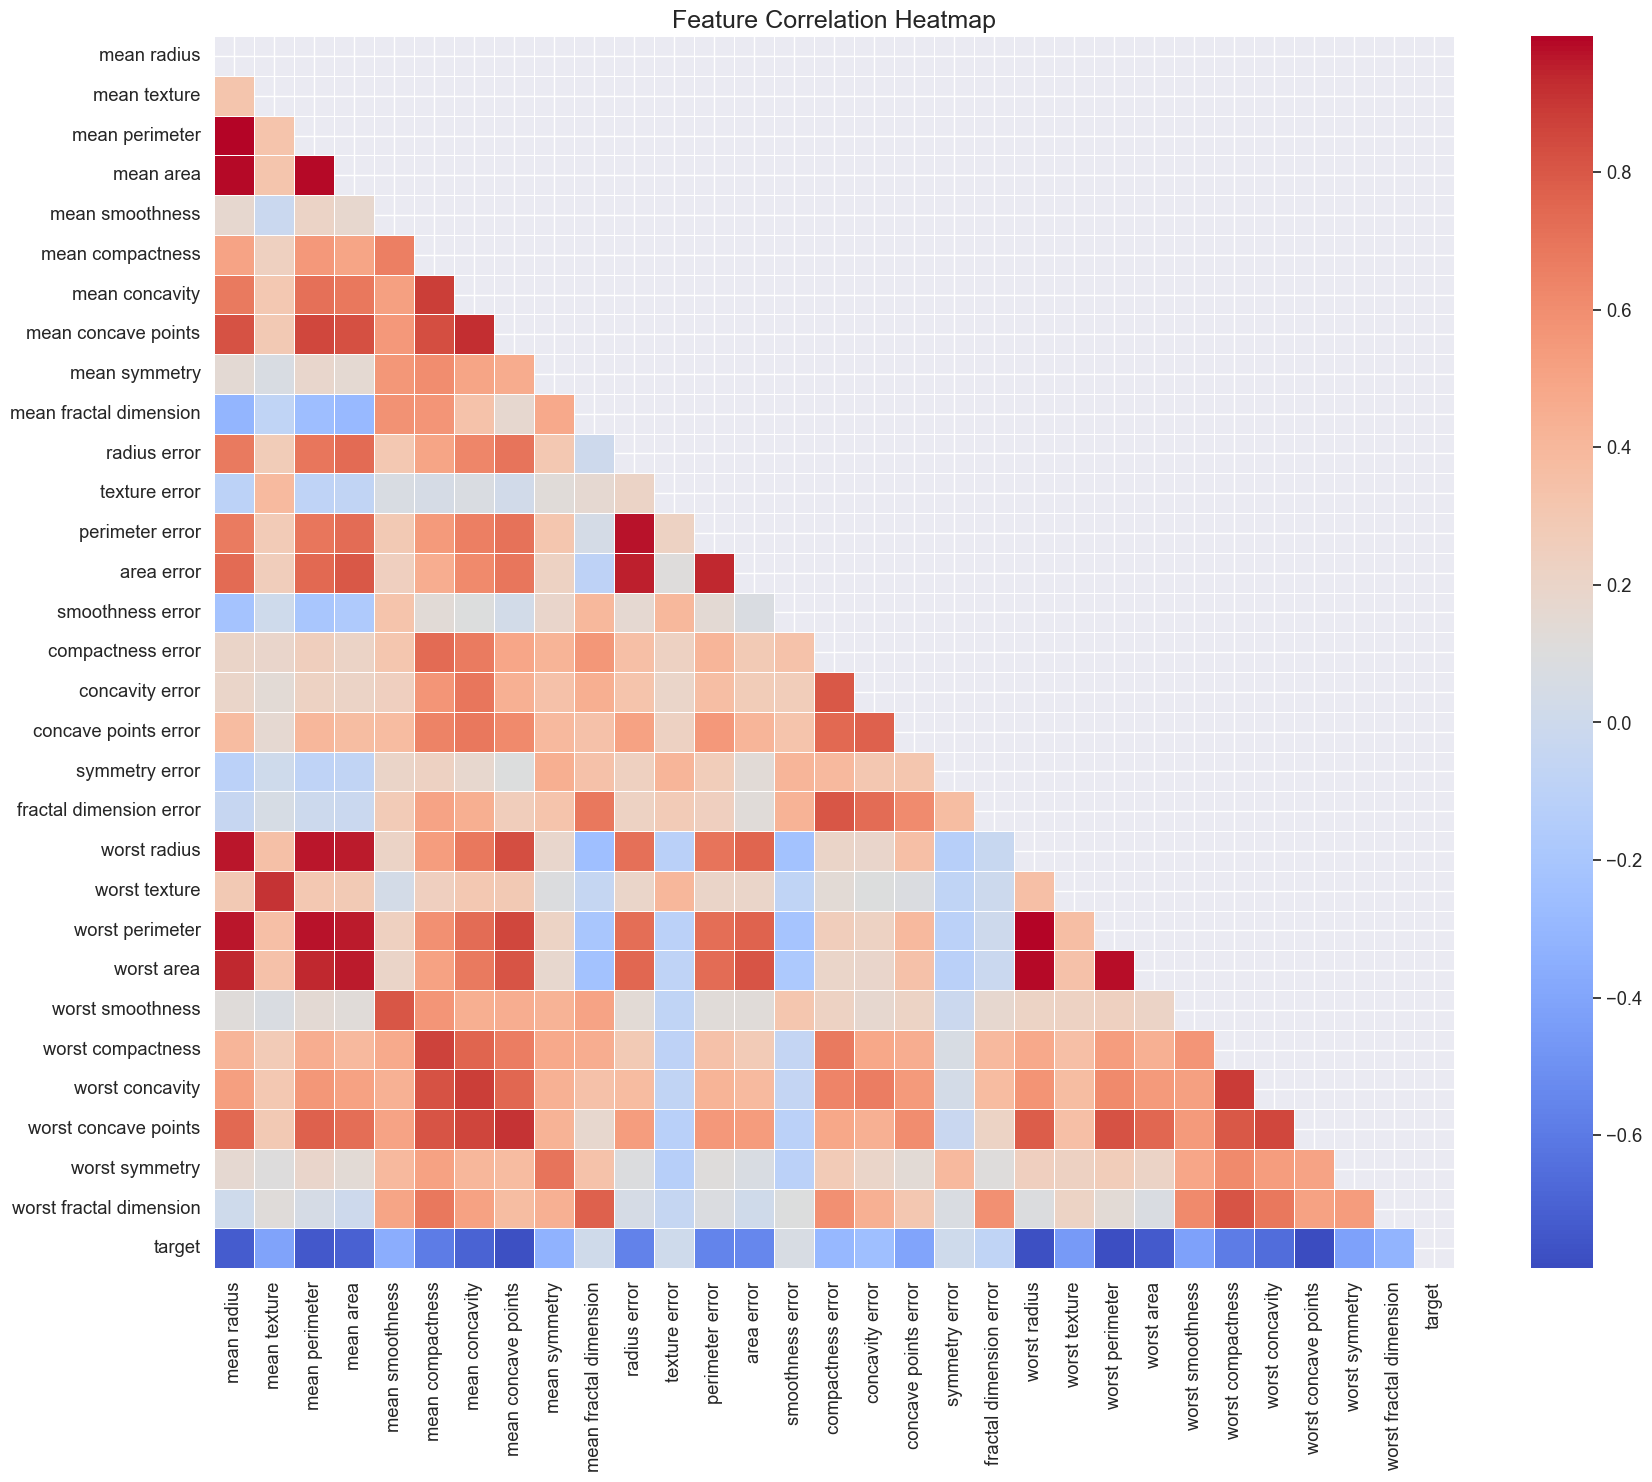

In [20]:
plt.figure(figsize=(20, 16))
correlation_matrix = data.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=18)
plt.show()

Visualize the distribution of features by target class

In [21]:
def plot_feature_distributions(features, n_cols=3):
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        ax = axes[i]
        for target, color in zip([0, 1], ['red', 'blue']):
            sns.kdeplot(data[data['target'] == target][feature], shade=True, color=color, label=f"Class {target}", ax=ax)
        ax.set_title(f"Distribution of {feature}")
        ax.legend()
    
    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

Plot distributions for the first 10 features

/var/folders/bb/vx6wvmwd1cgfb65nrzj1zfyh0000gn/T/ipykernel_42489/3938460325.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['target'] == target][feature], shade=True, color=color, label=f"Class {target}", ax=ax)
/var/folders/bb/vx6wvmwd1cgfb65nrzj1zfyh0000gn/T/ipykernel_42489/3938460325.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['target'] == target][feature], shade=True, color=color, label=f"Class {target}", ax=ax)
/var/folders/bb/vx6wvmwd1cgfb65nrzj1zfyh0000gn/T/ipykernel_42489/3938460325.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['target'] == target][feature], shad

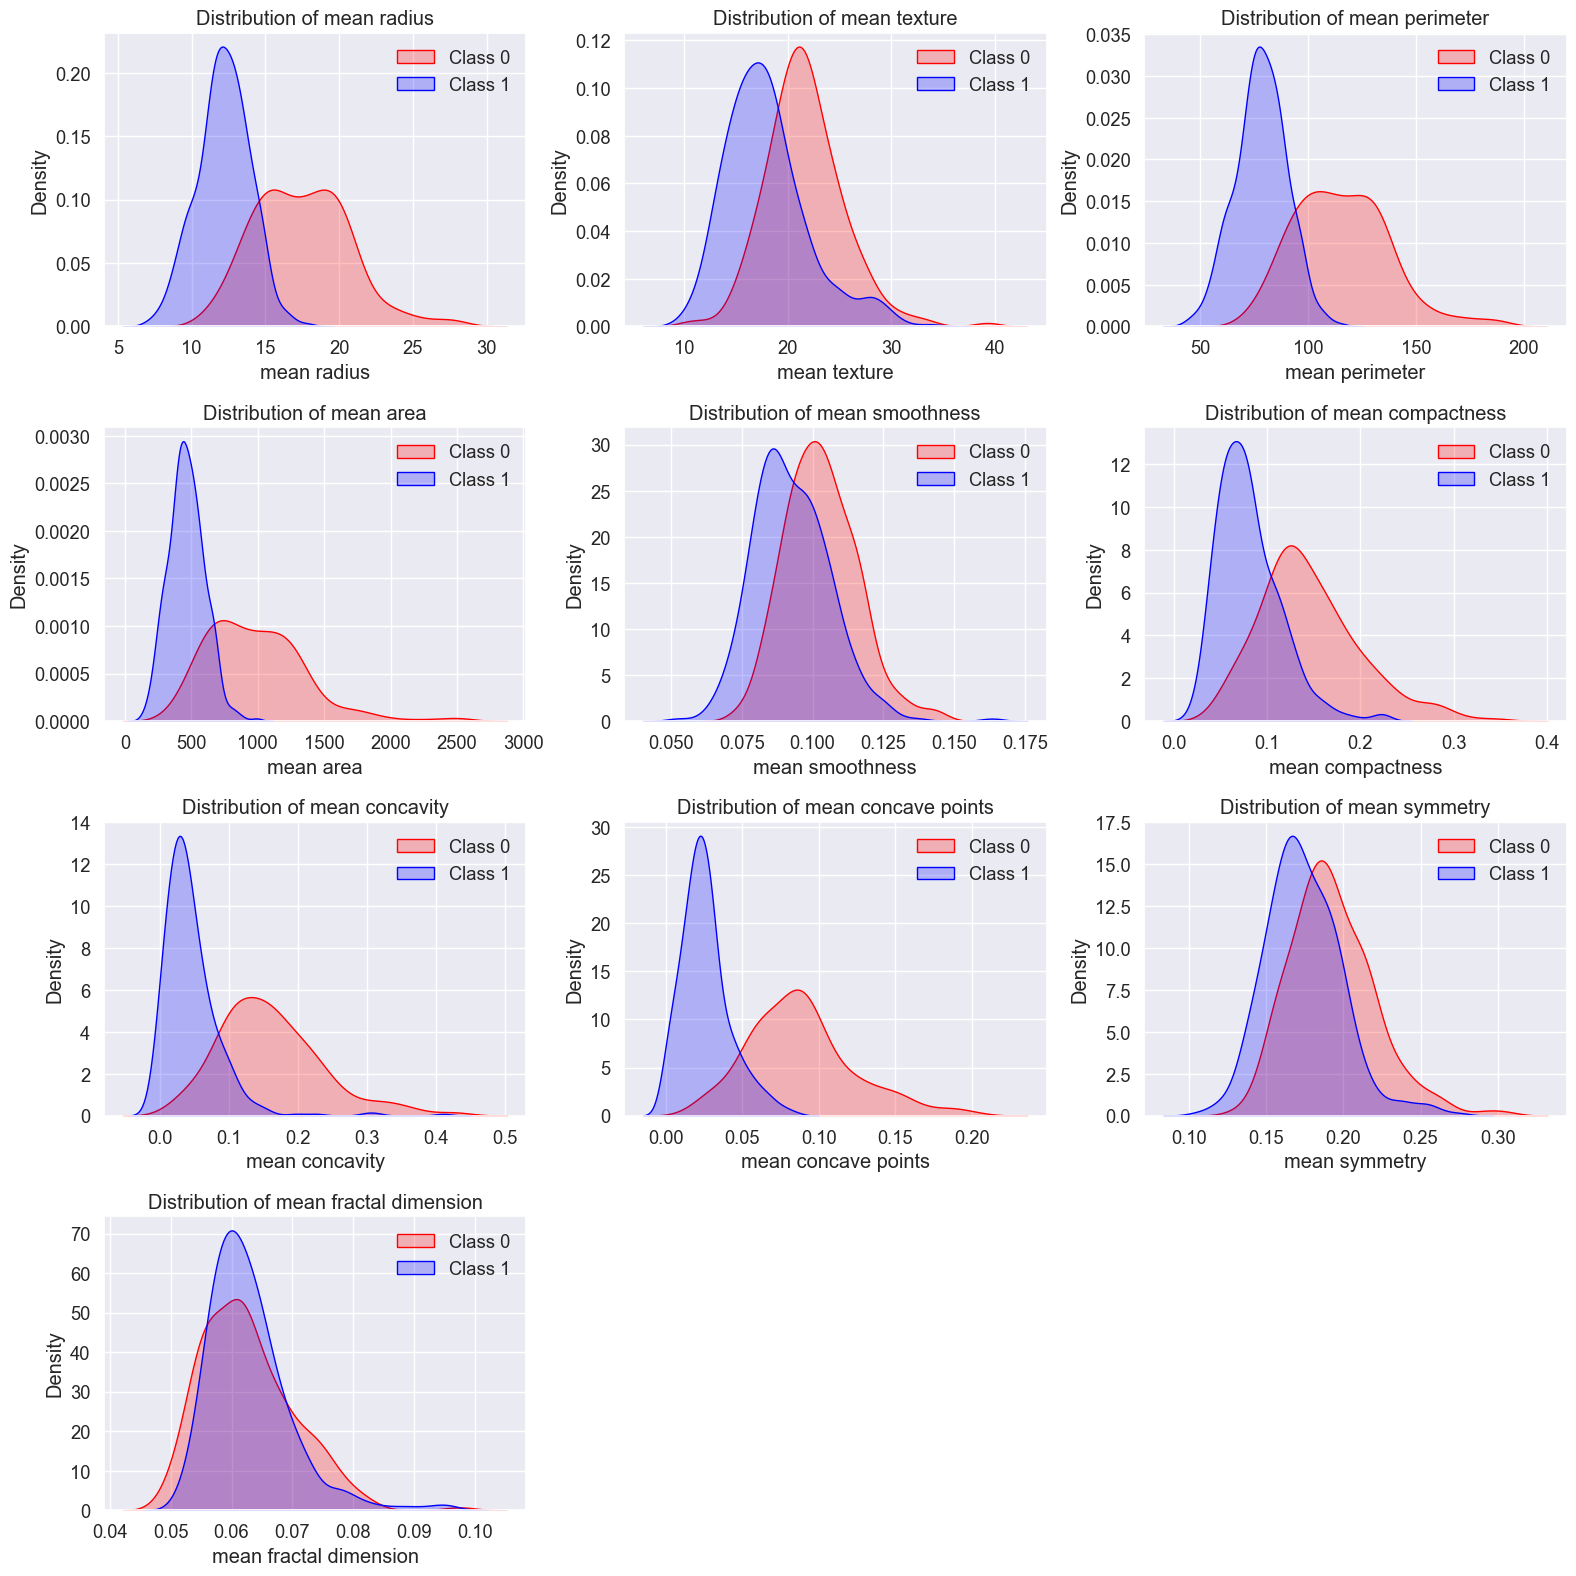

In [22]:
selected_features = cancer.feature_names[:10]
plot_feature_distributions(selected_features)

Box plots to detect outliers

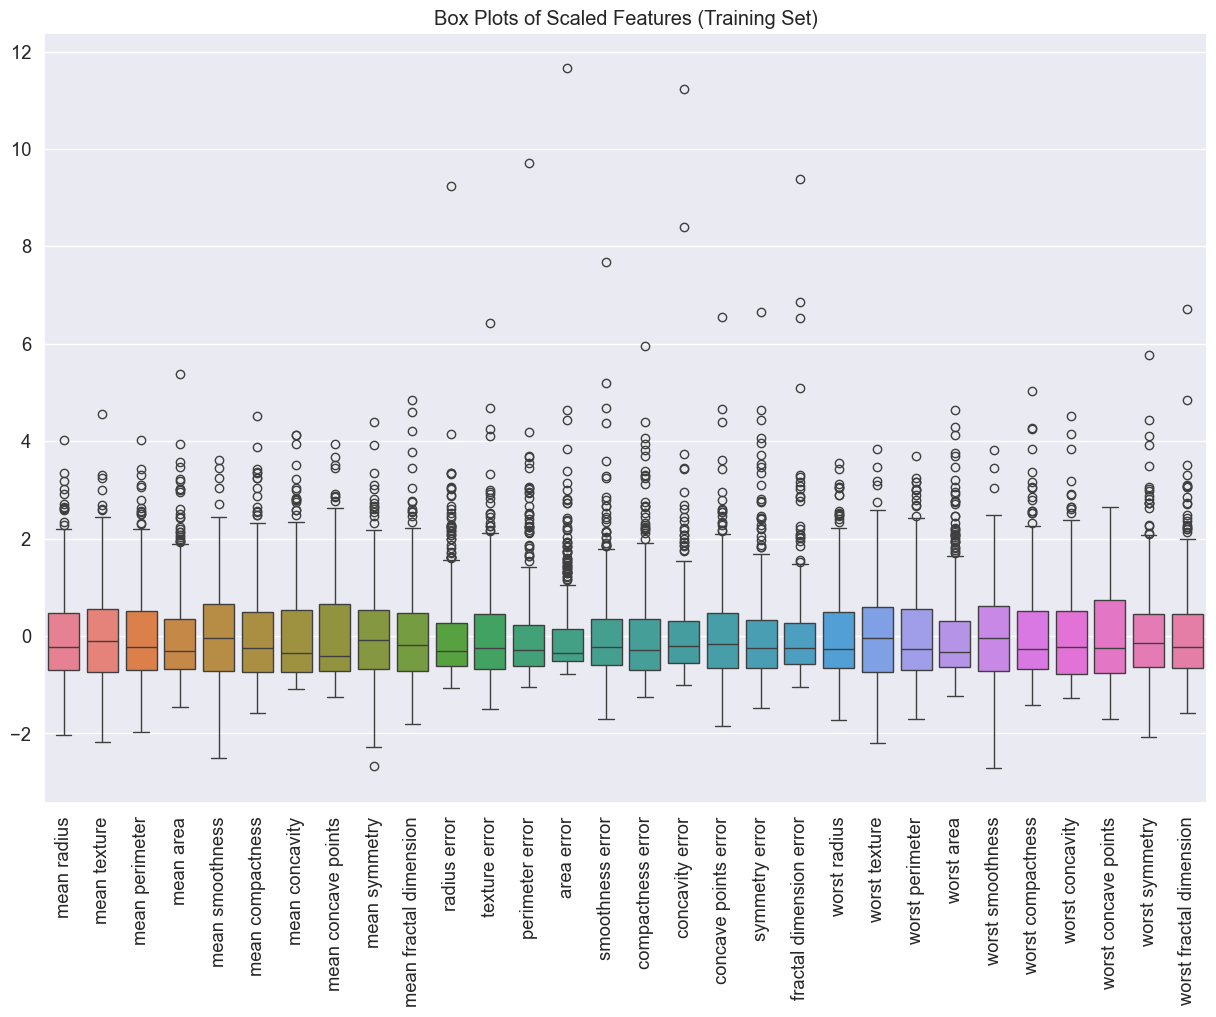

In [23]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=X_train_scaled_df)
plt.title('Box Plots of Scaled Features (Training Set)')
plt.xticks(rotation=90)
plt.show()

PCA for dimensionality reduction and visualization

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

Create a DataFrame for PCA results

In [25]:
pca_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'target': y_train.values
})

Plot the PCA results

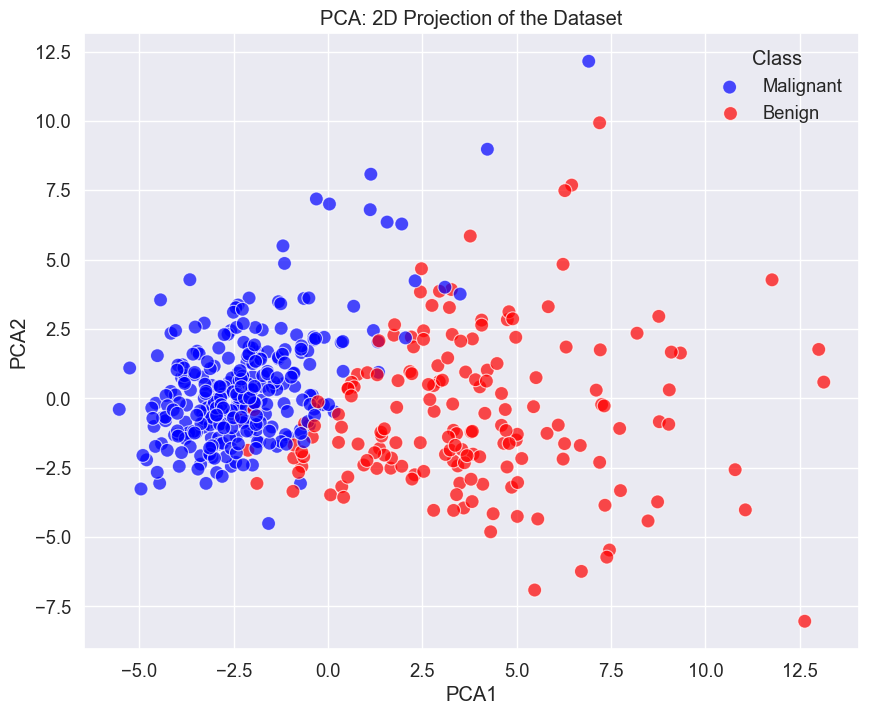

In [26]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='target', data=pca_df, palette={0: 'red', 1: 'blue'}, s=100, alpha=0.7)
plt.title('PCA: 2D Projection of the Dataset')
plt.legend(title='Class', labels=['Malignant', 'Benign'])
plt.show()

Explained variance ratio

In [27]:
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")

Explained variance ratio: [0.44413492 0.18944618]
Total explained variance: 0.63


Feature importance using Random Forest

In [28]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

Get feature importances

In [29]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

Plot feature importances

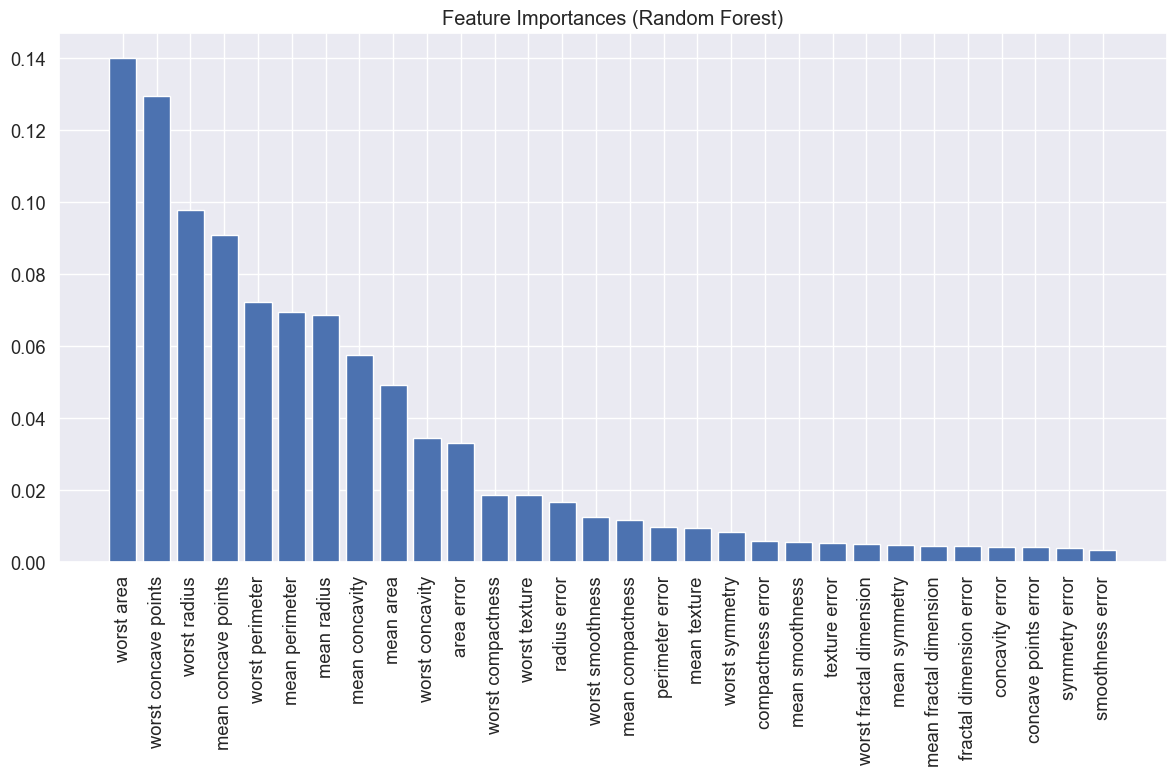

In [30]:
plt.figure(figsize=(12, 8))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

Print top 10 most important features

In [31]:
print("Top 10 most important features:")
for i in range(10):
    print(f"{i+1}. {X_train.columns[indices[i]]} - {importances[indices[i]]:.4f}")

Top 10 most important features:
1. worst area - 0.1400
2. worst concave points - 0.1295
3. worst radius - 0.0977
4. mean concave points - 0.0909
5. worst perimeter - 0.0722
6. mean perimeter - 0.0696
7. mean radius - 0.0687
8. mean concavity - 0.0576
9. mean area - 0.0492
10. worst concavity - 0.0343


## 4. Feature Selection and Engineering

Recursive Feature Elimination (RFE)

In [32]:
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=15)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

Get selected feature names

In [33]:
selected_features = X_train.columns[rfe.support_]
print("Selected features using RFE:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

Selected features using RFE:
1. mean radius
2. mean texture
3. mean perimeter
4. mean area
5. mean concavity
6. mean concave points
7. area error
8. worst radius
9. worst texture
10. worst perimeter
11. worst area
12. worst smoothness
13. worst concavity
14. worst concave points
15. worst symmetry


Create new features based on combinations of existing ones<br>
For example, create ratios between mean values and standard deviations

In [34]:
X_train_with_new_features = X_train_scaled_df.copy()
X_test_with_new_features = X_test_scaled_df.copy()

Create new features from ratios of existing features<br>
Extracting mean radius, texture, perimeter

In [38]:
mean_columns = [col for col in X_train.columns if 'mean' in col]
std_columns = [col for col in X_train.columns if 'std' in col]
mean_columns

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension']

Create ratios between different mean features

In [39]:
for i, col1 in enumerate(mean_columns):
    for col2 in mean_columns[i+1:]:
        # Extract feature names more safely
        feat1 = col1.replace('mean ', '').replace('mean_', '')
        feat2 = col2.replace('mean ', '').replace('mean_', '')
        ratio_name = f"ratio_{feat1}_{feat2}"
        
        X_train_with_new_features[ratio_name] = X_train_scaled_df[col1] / (X_train_scaled_df[col2] + 1e-10)
        X_test_with_new_features[ratio_name] = X_test_scaled_df[col1] / (X_test_scaled_df[col2] + 1e-10)

Create new features that are squares or cubes of important features

In [40]:
for col in mean_columns:
    X_train_with_new_features[f"{col}_squared"] = X_train_scaled_df[col] ** 2
    X_test_with_new_features[f"{col}_squared"] = X_test_scaled_df[col] ** 2

In [41]:
print(f"Number of original features: {X_train_scaled_df.shape[1]}")
print(f"Number of features after engineering: {X_train_with_new_features.shape[1]}")

Number of original features: 30
Number of features after engineering: 85


## 5. Model Training and Evaluation

We'll train and evaluate three models:<br>
1. Logistic Regression<br>
2. Random Forest Classifier<br>
3. XGBoost Classifier

Define a function to evaluate models

In [42]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Print results
    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Classification Report:\n{report}")
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return model, accuracy, roc_auc

1. Logistic Regression with hyperparameter tuning

In [43]:
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
}

In [44]:
lr_cv = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), 
                    lr_param_grid, 
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    scoring='roc_auc')
lr_cv.fit(X_train_scaled, y_train)

/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-pack

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc')

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Results:
Accuracy: 0.9825
ROC AUC: 0.9957
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



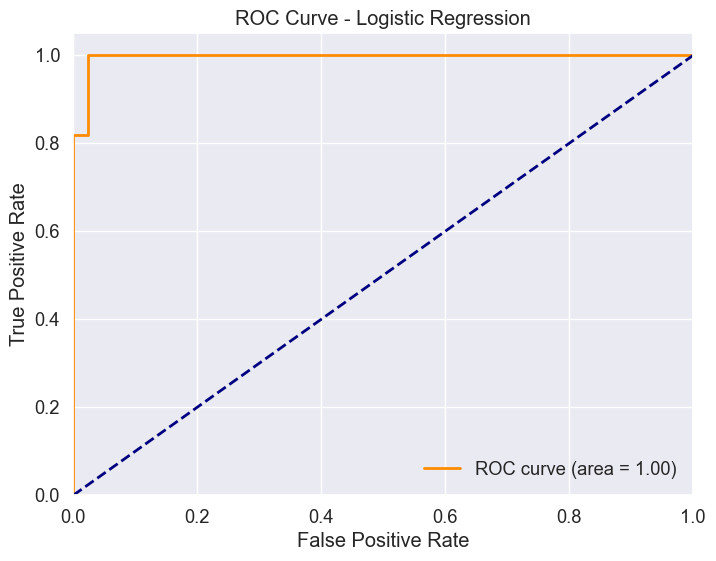

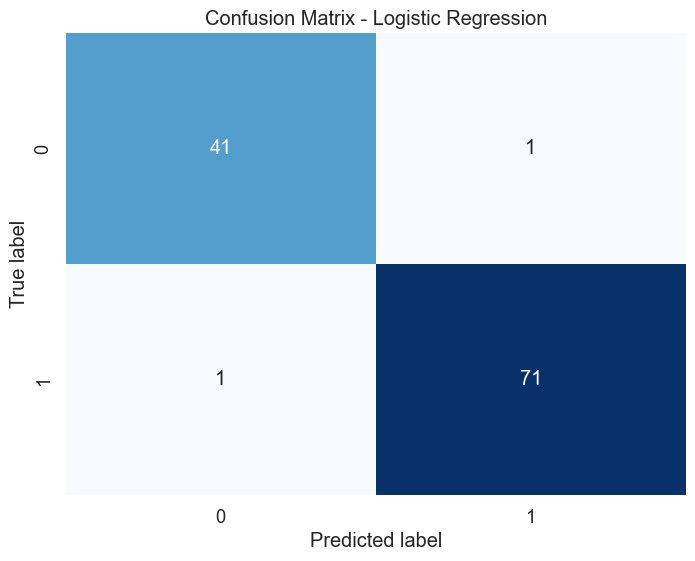

In [45]:
print(f"Best parameters for Logistic Regression: {lr_cv.best_params_}")
lr_best = lr_cv.best_estimator_
lr_model, lr_accuracy, lr_auc = evaluate_model(lr_best, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression")

2. Random Forest with hyperparameter tuning

In [46]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [47]:
rf_cv = GridSearchCV(RandomForestClassifier(random_state=42), 
                    rf_param_grid, 
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    scoring='roc_auc')
rf_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Results:
Accuracy: 0.9561
ROC AUC: 0.9934
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



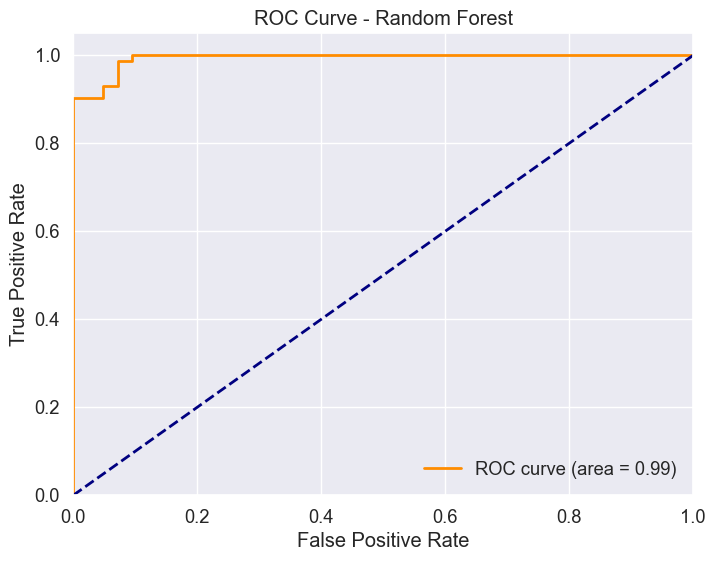

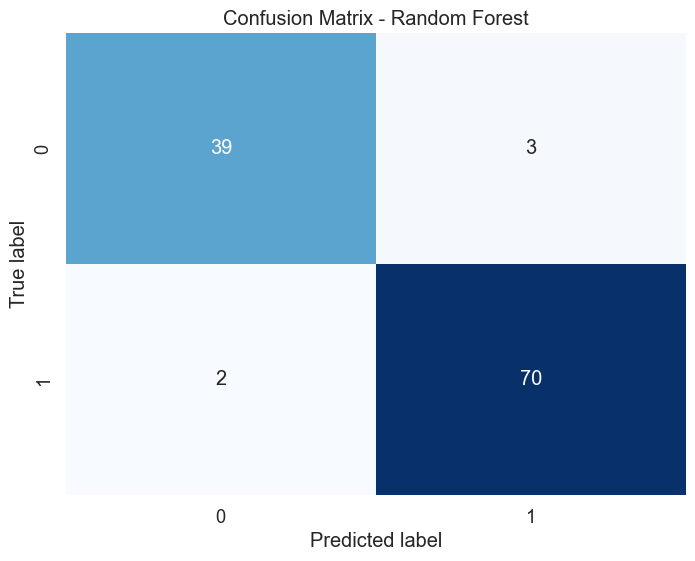

In [48]:
print(f"Best parameters for Random Forest: {rf_cv.best_params_}")
rf_best = rf_cv.best_estimator_
rf_model, rf_accuracy, rf_auc = evaluate_model(rf_best, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")

3. XGBoost with hyperparameter tuning

In [49]:
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [50]:
xgb_cv = GridSearchCV(XGBClassifier.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), 
                     xgb_param_grid, 
                     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                     scoring='roc_auc')
xgb_cv.fit(X_train_scaled, y_train)

/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:28:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:28:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:28:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-packages/x

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc')

Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
XGBoost Results:
Accuracy: 0.9561
ROC AUC: 0.9940
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:28:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


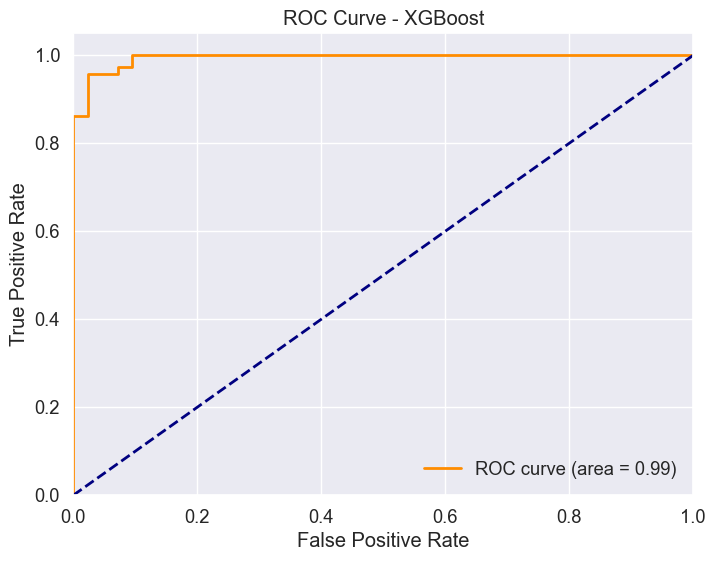

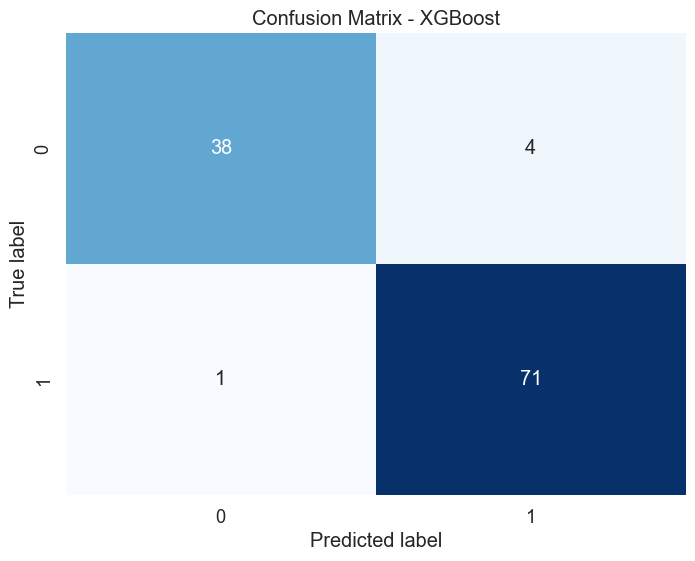

In [51]:
print(f"Best parameters for XGBoost: {xgb_cv.best_params_}")
xgb_best = xgb_cv.best_estimator_
xgb_model, xgb_accuracy, xgb_auc = evaluate_model(xgb_best, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost")

Evaluate models on engineered features


Performance with Feature Engineering:
Random Forest with Engineered Features Results:
Accuracy: 0.9561
ROC AUC: 0.9934
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



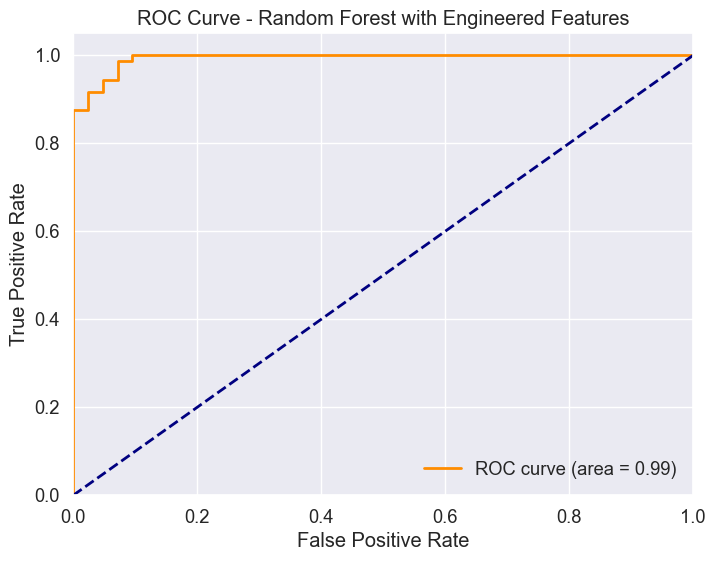

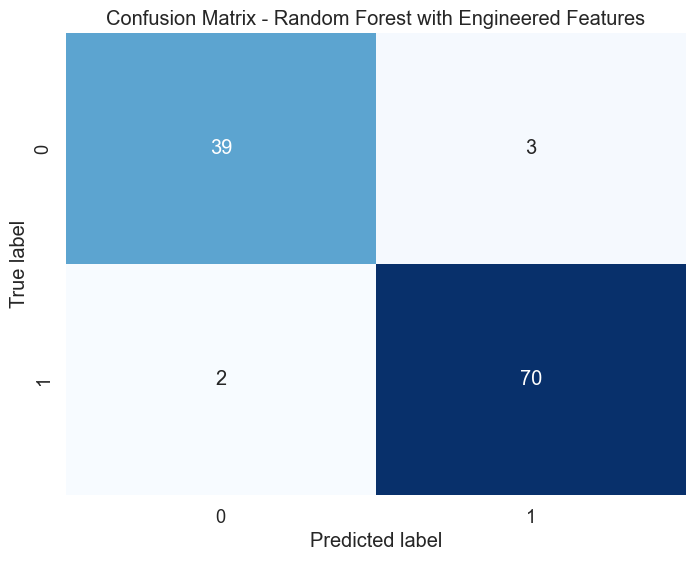

In [52]:
print("\nPerformance with Feature Engineering:")
rf_model_eng, rf_accuracy_eng, rf_auc_eng = evaluate_model(rf_best, 
                                                         X_train_with_new_features, 
                                                         y_train, 
                                                         X_test_with_new_features, 
                                                         y_test, 
                                                         "Random Forest with Engineered Features")

## 6. Model Improvement Techniques

Using SMOTE to handle class imbalance

In [53]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [54]:
print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_smote))

Before SMOTE: [170 285]
After SMOTE: [285 285]


Train the best model on SMOTE-resampled data


Performance after applying SMOTE:
Random Forest with SMOTE Results:
Accuracy: 0.9474
ROC AUC: 0.9950
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        42
           1       0.99      0.93      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



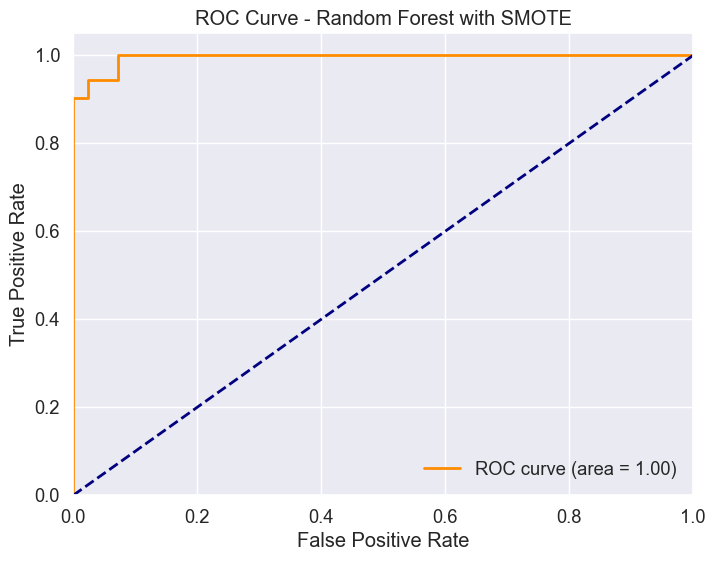

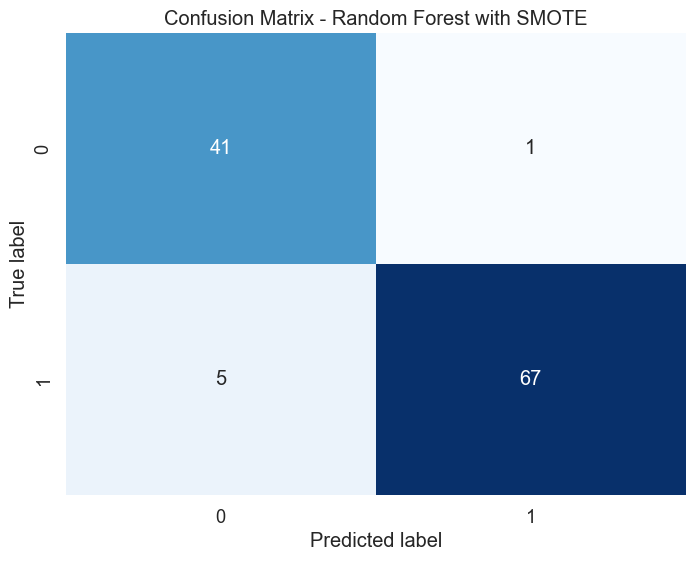

In [55]:
print("\nPerformance after applying SMOTE:")
rf_model_smote, rf_accuracy_smote, rf_auc_smote = evaluate_model(RandomForestClassifier(**rf_cv.best_params_, random_state=42), 
                                                               X_train_smote, 
                                                               y_train_smote, 
                                                               X_test_scaled, 
                                                               y_test, 
                                                               "Random Forest with SMOTE")

Stacking Ensemble

In [56]:
from sklearn.ensemble import StackingClassifier
estimators = [
    ('rf', RandomForestClassifier(**rf_cv.best_params_, random_state=42)),
    ('lr', LogisticRegression(**lr_cv.best_params_, random_state=42)),
    ('xgb', XGBClassifier.XGBClassifier(**xgb_cv.best_params_, random_state=42, use_label_encoder=False, eval_metric='logloss'))
]

In [57]:
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)


Stacking Ensemble Performance:


/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:29:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jibinbaby/Documents/DataEngineering/Health_Projects/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:29:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Stacking Ensemble Results:
Accuracy: 0.9561
ROC AUC: 0.9957
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



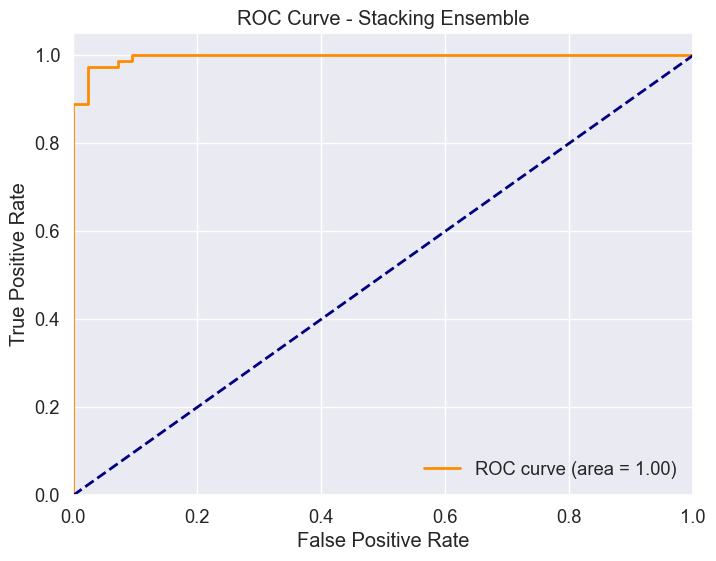

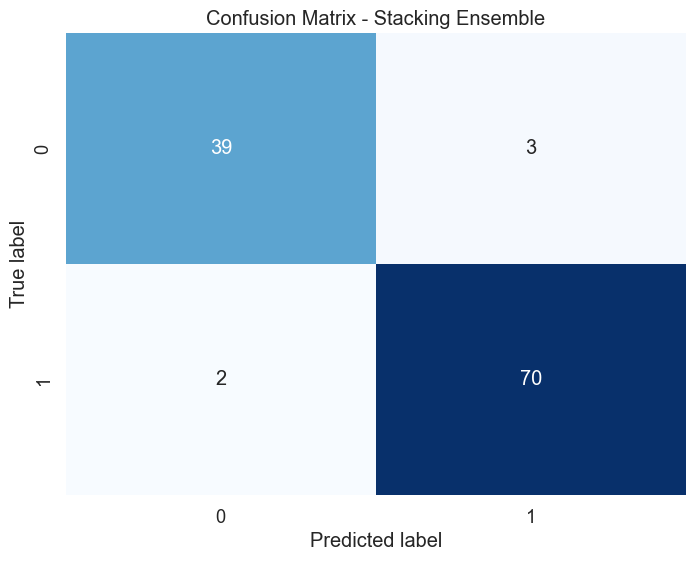

In [58]:
print("\nStacking Ensemble Performance:")
stacking_clf, stacking_accuracy, stacking_auc = evaluate_model(stacking_model, 
                                                             X_train_scaled, 
                                                             y_train, 
                                                             X_test_scaled, 
                                                             y_test, 
                                                             "Stacking Ensemble")

## 7. Model Interpretability with SHAP

Apply SHAP to explain the best model (using XGBoost for SHAP as it's well supported)<br>
This will help understand how each feature influences the prediction

In [59]:
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test_scaled)

Summarize the effects of all features

/var/folders/bb/vx6wvmwd1cgfb65nrzj1zfyh0000gn/T/ipykernel_42489/3637467676.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns, show=False)


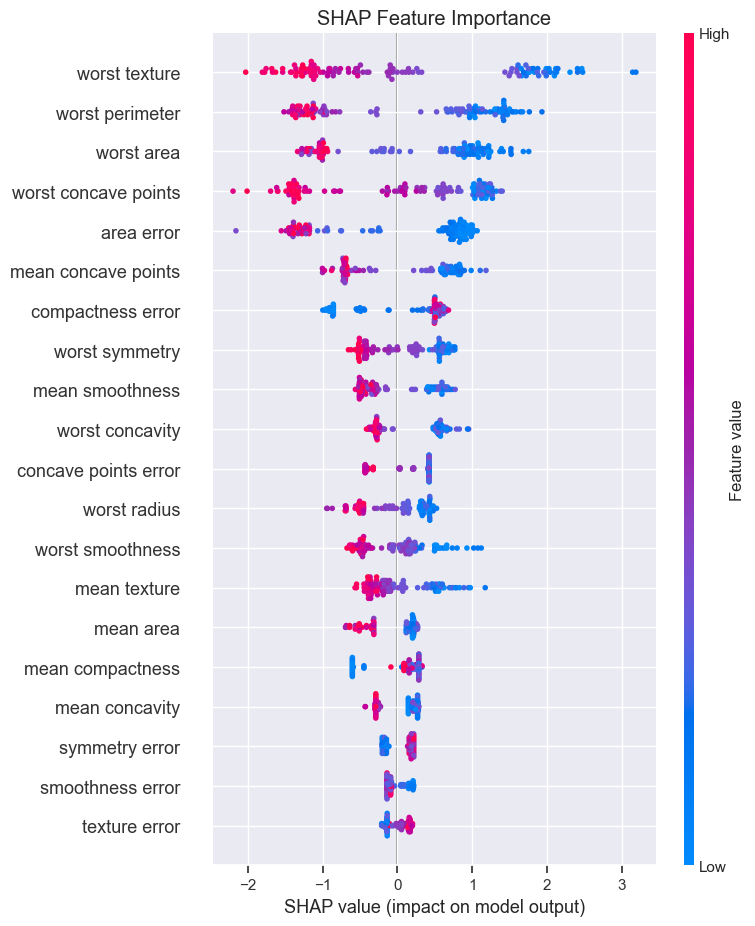

In [60]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

Detail plot for a sample instance

<Figure size 1200x600 with 0 Axes>

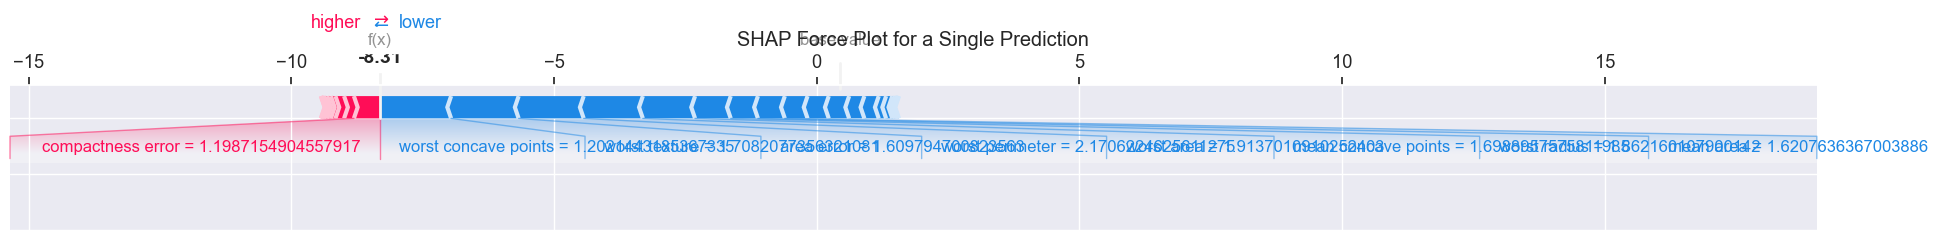

In [61]:
plt.figure(figsize=(12, 6))
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_scaled[0,:], feature_names=X_test.columns, matplotlib=True, show=False)
plt.title("SHAP Force Plot for a Single Prediction")
plt.tight_layout()
plt.show()

## 8. Saving and Loading the Model

Save the best performing model

In [62]:
best_model = stacking_clf if stacking_accuracy > rf_accuracy and stacking_accuracy > xgb_accuracy else (rf_model if rf_accuracy > xgb_accuracy else xgb_model)
model_filename = 'breast_cancer_classifier.joblib'
joblib.dump(best_model, model_filename)
print(f"Best model saved as {model_filename}")

Best model saved as breast_cancer_classifier.joblib


Also save the scaler for preprocessing new data

In [63]:
scaler_filename = 'breast_cancer_scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved as {scaler_filename}")

Scaler saved as breast_cancer_scaler.joblib


Example of loading and using the model

In [64]:
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)

Create a function to make predictions on new data

In [65]:
def predict_cancer(new_data, model=loaded_model, scaler=loaded_scaler):
    # Scale the data using the saved scaler
    scaled_data = scaler.transform(new_data)
    # Make predictions
    prediction = model.predict(scaled_data)
    probability = model.predict_proba(scaled_data)[:, 1]
    return prediction, probability

Example: Make prediction on the first test sample

In [66]:
sample = X_test.iloc[[0]]
prediction, probability = predict_cancer(sample)
print(f"Prediction for sample: {'Benign' if prediction[0] == 1 else 'Malignant'}")
print(f"Probability of being benign: {probability[0]:.4f}")

Prediction for sample: Malignant
Probability of being benign: 0.0002


## 9. Summary and Conclusion

Compare all models

In [67]:
models = {
    'Logistic Regression': lr_accuracy,
    'Random Forest': rf_accuracy,
    'XGBoost': xgb_accuracy,
    'Random Forest with Engineered Features': rf_accuracy_eng,
    'Random Forest with SMOTE': rf_accuracy_smote,
    'Stacking Ensemble': stacking_accuracy
}

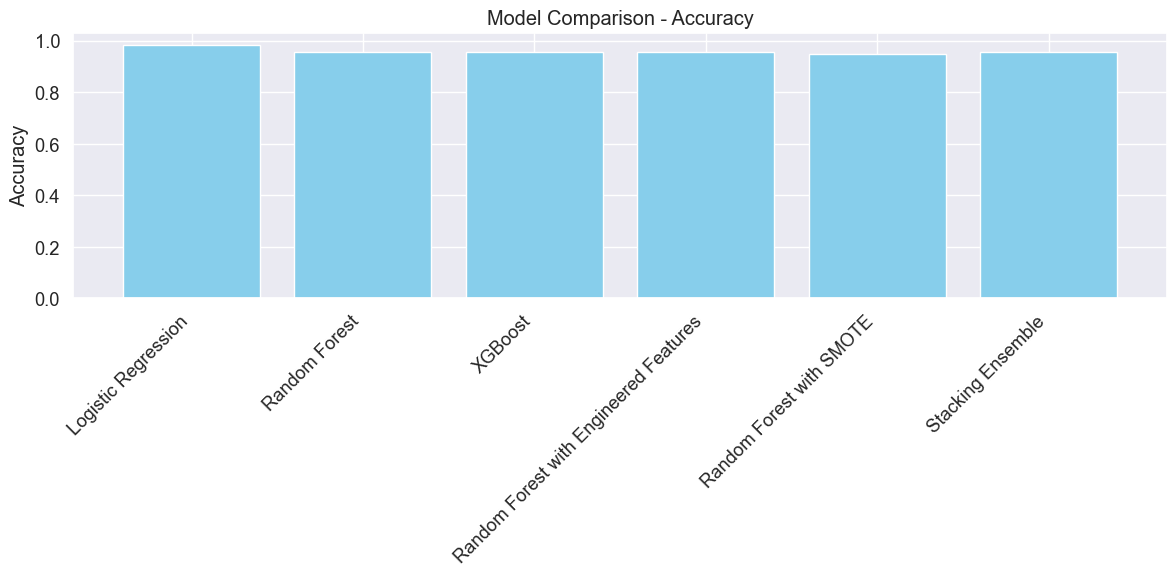

In [68]:
plt.figure(figsize=(12, 6))
plt.bar(models.keys(), models.values(), color='skyblue')
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Print final results

In [69]:
print("\nFinal Model Comparison (Accuracy):")
for model_name, accuracy in sorted(models.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {accuracy:.4f}")


Final Model Comparison (Accuracy):
Logistic Regression: 0.9825
Random Forest: 0.9561
XGBoost: 0.9561
Random Forest with Engineered Features: 0.9561
Stacking Ensemble: 0.9561
Random Forest with SMOTE: 0.9474


In [70]:
print("\nKey Findings:")
print("1. The most important features for predicting cancer malignancy are:")
for i in range(5):
    print(f"   - {X_train.columns[indices[i]]}")


Key Findings:
1. The most important features for predicting cancer malignancy are:
   - worst area
   - worst concave points
   - worst radius
   - mean concave points
   - worst perimeter


In [71]:
print("\n2. Feature engineering and ensemble methods improved model performance.")
print(f"3. The best model achieved an accuracy of {max(models.values()):.4f}.")
print("4. SHAP analysis provided interpretability, showing how each feature contributes to predictions.") 


2. Feature engineering and ensemble methods improved model performance.
3. The best model achieved an accuracy of 0.9825.
4. SHAP analysis provided interpretability, showing how each feature contributes to predictions.
